# MRMS precipitation rates

This notebook illustrates how to download and open instantaneous precipitation rates from the [Multi-Radar/Multi-Sensor System](https://www.nssl.noaa.gov/projects/mrms/)

> **Note:** Since MRMS data is stored using grib2 format, loading the data into an xarray Dataset requires the [cfgrib](http://xarray.pydata.org/en/stable/examples/ERA5-GRIB-example.html) package and its dependencies to be installed.

## Downloading the data

The MRMS instantaneous precipitation rate product is represented by the ``precip_rate`` product object of the ``pansat.products.ground_based.mrms`` module. After importing it, the object can be used to download data for an arbitrary time range. For this specific example, we will look at the instantaneous precipitation for one day of the [2021 February snow storms](https://en.wikipedia.org/wiki/February_13%E2%80%9317,_2021_North_American_winter_storm).

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from pansat.products.ground_based import mrms

In [2]:
from pansat.time import TimeRange
time = np.datetime64("2021-02-15T08:01:00")
files = mrms.precip_rate.download(time)

In [3]:
files

[PosixPath('MRMS/PrecipRate_00.00_20210215-080000.grib2.gz')]

## Loading the data

If the ``cfgrib`` package is available on your system, the data can be read directly into an xarray Dataset.

In [4]:
data = mrms.precip_rate.open(files[0])
display(data)

<xarray.Dataset>
Dimensions:         (latitude: 3500, longitude: 7000)
Coordinates:
    time            datetime64[ns] 2021-02-15T08:00:00
    step            timedelta64[ns] 00:00:00
    heightAboveSea  float64 0.0
  * latitude        (latitude) float64 54.99 54.98 54.98 ... 20.03 20.02 20.01
  * longitude       (longitude) float64 -130.0 -130.0 -130.0 ... -60.02 -60.01
    valid_time      datetime64[ns] 2021-02-15T08:00:00
Data variables:
    precip_rate     (latitude, longitude) float32 -3.0 -3.0 -3.0 ... -3.0 -3.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2023-09-24T18:22 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
data.longitude.min(), data.longitude.max()

(<xarray.DataArray 'longitude' ()>
 array(-129.995)
 Coordinates:
     time            datetime64[ns] 2021-02-15T08:00:00
     step            timedelta64[ns] 00:00:00
     heightAboveSea  float64 0.0
     valid_time      datetime64[ns] 2021-02-15T08:00:00,
 <xarray.DataArray 'longitude' ()>
 array(-60.005002)
 Coordinates:
     time            datetime64[ns] 2021-02-15T08:00:00
     step            timedelta64[ns] 00:00:00
     heightAboveSea  float64 0.0
     valid_time      datetime64[ns] 2021-02-15T08:00:00)

In [11]:
data.latitude.min(), data.latitude.max()

(<xarray.DataArray 'latitude' ()>
 array(20.005001)
 Coordinates:
     time            datetime64[ns] 2021-02-15T08:00:00
     step            timedelta64[ns] 00:00:00
     heightAboveSea  float64 0.0
     valid_time      datetime64[ns] 2021-02-15T08:00:00,
 <xarray.DataArray 'latitude' ()>
 array(54.995)
 Coordinates:
     time            datetime64[ns] 2021-02-15T08:00:00
     step            timedelta64[ns] 00:00:00
     heightAboveSea  float64 0.0
     valid_time      datetime64[ns] 2021-02-15T08:00:00)

## Displaying the data

To display the data, we replace 0 values with small positive values so that we can distinguish them from the missing values, which are negative. We also subsample the data slightly to make the plotting faster.

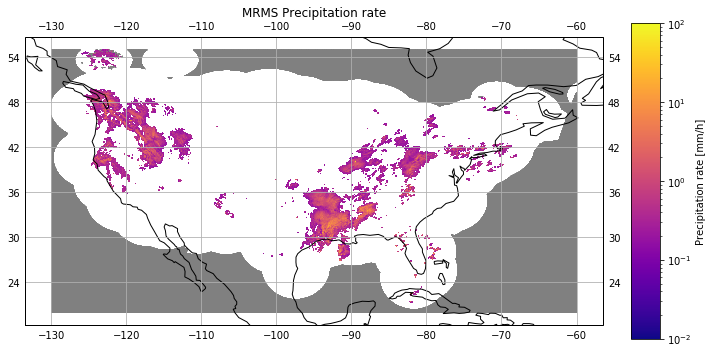

In [25]:
from copy import copy
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib.cm import get_cmap
import cartopy.crs as ccrs

gs = GridSpec(1, 2, width_ratios=[1.0, 0.05])
f = plt.figure(figsize=(10, 5))
ax = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())

lats = data["latitude"].data[::3]
lons = data["longitude"].data[::3]
precip_rate = data["precip_rate"].data[::3, ::3]
# Set zero values to small value so that they can be distinguished
# from missing data.
precip_rate[precip_rate == 0.0] = 1e-6

norm = LogNorm(1e-2, 1e2)
cmap = copy(get_cmap("plasma"))
cmap.set_under([0.0, 0.0, 0.0, 0.0])
cmap.set_bad([0.5, 0.5, 0.5, 0.5])
m = ax.pcolormesh(lons, lats, precip_rate.data, norm=norm, cmap=cmap)
ax.coastlines()
ax.set_title("MRMS Precipitation rate", pad=20)
ax.set_xlabel(r"Longitude [$^\deg$ W]")
ax.set_ylabel(r"Latitude [$^\deg$ N]")
ax.gridlines(draw_labels=True)

ax = plt.subplot(gs[0, 1])
plt.colorbar(m, cax=ax, label="Precipitation rate [mm/h]")

f.canvas.draw()
plt.tight_layout()